In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import BDay
from hsmm_core.hmm import hmm_engine
from hsmm_core.observation_models import ExpIndMixDiracGauss
from hsmm_core.data_utils import load_data, TradingHours
from hsmm_core.data_utils import load_data, TradingHours
from hsmm_core.feature_spaces import hmm_features
from hsmm_core.hmm import hmm_calibration
from hsmm_core.data_utils import load_data, TradingHours
from hsmm_core.labelling import DataLabellingSimple
from hsmm_core.consts import ThresholdMethod, LabellingChoice
import pickle
from hsmm_core.consts import InitialisationMethod
import datetime as dt
plt.style.use('ggplot')
%matplotlib inline


In [3]:

ticker = 'test_SYNT_2states'


data_dir = os.getenv('FINANCE_DATA')
features_path='/home/ak/Data/features_models/features/'
labels_path= '/home/ak/Data/features_models/labels'

ticker_labels_path = os.path.join(labels_path,ticker+'/NON_DIRECTIONAL')

if not os.path.exists(os.path.join(data_dir, ticker)):
    os.makedirs(os.path.join(data_dir, ticker))
    
if not os.path.exists(ticker_labels_path):
    os.makedirs(ticker_labels_path)

    ####paths####
main_path = '/home/ak/Data/features_models/'

models_path=os.path.join(main_path,'models')
ticker_models_path = os.path.join(models_path, ticker)
# hmm_models_path = os.path.join(models_path,'hmm_models')
# features_ticker_path = os.path.join(features_path, ticker)
# predictions_path = os.path.join(main_path, 'predictions')
if not os.path.exists(ticker_models_path):
    os.makedirs(ticker_models_path)


In [4]:

no_states = 2
sigmas = [0.05, 0.002] # fast and slow
# Duration is measured in seconds for now (to be revised). lambda units are seconds^{-1}
# so here we consider

lambdas = [1./35., 1./10.]
weights = [0.1, 0.6]

obs_model = ExpIndMixDiracGauss(no_states)
obs_model.set_up_initials(priors={'sigmas': sigmas, 'lambdas': lambdas, 'weights': weights})

hmm_ = hmm_engine(obs_model, no_states)

# set up some priors
tpm = np.array([[0.4, 0.6], [0.7, 0.3]])
pi = np.array([0.4, 0.6])
hmm_.set_up_initials(priors={'tpm': tpm, 'pi': pi})

no_dates = 30
start_date = pd.datetime(2017, 6, 1)
dummy_dates = [start_date + BDay(i) for i in range(no_dates)]

no_points = 5000

rng = np.random.RandomState(1234)



In [5]:

# silly hack, add 1 millisecond so that the initial timestamp is printed with milliseconds and does not
# break the parsing of Timestamps when loading

morning_start = dt.time(8, 0, 0, 1)

initial_price = 100

for dd in dummy_dates:
    random_states = hmm_.sample_states(rng=rng, length=no_points)
    observation_points = obs_model.sample_data(no_points, rng=rng, state=random_states)
    # The first duration is always zero
    observation_points[0, 0] = 0.

    file_path = os.path.join(data_dir, ticker)
    file_name = '.'.join([dd.strftime('%Y%m%d'), 'csv'])

    data_to_save = pd.DataFrame({'states': random_states,
                                 'Duration': observation_points[:, 0],
                                 'ReturnTradedPrice': observation_points[:, 1],
                                 })
    data_to_save['TradedTime'] = pd.Series()

    # Now calculate the Traded prices and traded times in reverse order as to what would happen
    # with real data.
    # data_to_save.loc[0, 'TradedTime'] = dt.datetime.combine(dd.date(), morning_start)
    data_to_save['TradedTime'] = data_to_save['Duration'].cumsum().apply(lambda dur:
                                                                         (dt.datetime.combine(dd.date(), morning_start)+\
                                                                                     dt.timedelta(seconds=dur)).time())

    data_to_save['TradedPrice'] = initial_price * (1. + data_to_save['ReturnTradedPrice']).cumprod()
    data_to_save.to_csv(os.path.join(file_path, file_name), index=False)

print "ok"


ok


### Feature Creation ###

In [6]:

n_hidden_states = no_states

init_params = {
    "obs_model_params": {
                                'obs_model_name': 'ExpIndMixDiracGauss',
                                'em_init_method': InitialisationMethod.cluster

    },
    "hidden_model_params": {
                                'no_hidden_states': no_states,
                                'pi':pi,
                                'tpm': tpm,
                                'em_init_method': InitialisationMethod.uniform
    },
    "update_tag": 'tpsml'
}


data = load_data(ticker, which_trading_hours=TradingHours.all_trading_day)

from itertools import permutations, product
windows =[2, 5, 10, 25, 100]
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
print list(product(windows, thresholds))
type(zip(windows,thresholds))

In [7]:
# ticker = 'SYNT_2states'
# ticker = 'SYNT_4states'

features_path = os.path.join(main_path, 'features')
ticker_labels_path = os.path.join(labels_path, ticker)
# ticker_models_path = os.path.join(models_path, ticker)
# ticker_predictions_path = os.path.join(predictions_path, ticker)

ticker_features_path = os.path.join(features_path, ticker)

###

# list of files    
labels_list = os.listdir(ticker_labels_path)

# features_list = os.listdir(ticker_features_path)


for label_init in label_perms:
    print label_init
    labeller = DataLabellingSimple(label_init)
#     DataLabellingSimple(label_init).label_training_data(data)

## create labels ##

In [8]:



# labelling_method_params = [{

#     'labelling_method': LabellingChoice.price_move_in_window,
#     'rolling_window': window,
#     # Uncomment below if you want to check a price move only above a certain level
#     'updown_threshold': threshold, #this is multiplied by 100
#     'threshold_method': ThresholdMethod.arbitrary,
# }]

# for label_init in labelling_method_params:
#     print label_init
#     labeller = DataLabellingSimple(label_init)
#     labeller.label_training_data(data)

# keys_ = data.keys()

# for key_, _ in enumerate(keys_):
#     data[keys_[key_]].to_csv(ticker_labels_path+'/'+str(keys_[key_])+'.csv', index=False)
def labelling_method_params(window, threshold):
    labelling_method_params = {
        'labelling_method': LabellingChoice.price_move_in_window,
        'rolling_window': window,
        # Uncomment below if you want to check a price move only above a certain level
        'updown_threshold': threshold, #this is multiplied by 100
        'threshold_method': ThresholdMethod.arbitrary,
    }
    return labelling_method_params
# cur = [[14, k, j] for j, k in map(None,rows[14], range(15))]
#cur = [[14, k, j] for j, k in zip(rows[14], range(15))]

In [9]:
windows =[5, 10, 15, 25, 50, 100]
thresholds =[0.001, 0.01, 0.1, 0.05]
# test=labelling_method_params(window, threshold)
from itertools import product
dictlist = [labelling_method_params(window, threshold) for window, threshold in product(windows,thresholds)]


In [10]:
for perm_idx, label_init in enumerate(dictlist):
    labeller = DataLabellingSimple(label_init)
    labeller.label_training_data(data)

In [14]:
from collections import defaultdict
dates=data.keys()    
ratios_dict = {}
summaries_dict ={}

def new_label(label):
    new_label=''.join(('W:',label.split('_')[4],'-T:',label.split('_')[9]))
    return new_label

for idx, date in enumerate(dates):

    labels_df= data[dates[idx]].drop(columns=['ReturnTradedPrice','Duration','states', \
                                              'TradedTime','TradedPrice','ticker'], axis=1)
    summary_df=pd.DataFrame(labels_df.apply(pd.value_counts).T)
    labels_names =summary_df.T.columns.values
    new_labels_list =[new_label(labels_names[idx_value]) for idx_value, _ in enumerate(labels_names)]
    summary_df['ratio']=summary_df[0]/summary_df[1]
    ratio_df = summary_df.set_index([new_labels_list])
    summaries_dict[idx] = ratio_df['ratio']
 

   
    
#     print ratio_df.head(5)
#     plt.figure(figsize=(20,10))
# #     labels_names =summary_df.T.columns.values
#     new_labels_list =[new_label(labels_names[idx]) for idx, _ in enumerate(labels_names)]
    
#     ratio.plot.bar()
#     l = plt.axhline(y=1,linewidth= 0.5, linestyle=':')
#     l.set_label('Label via method')
#     plt.title(r'#$\xi =0$ / #$\xi <>0$')
#     plt.ylabel('Ratio')
# #     labels =summary_df.T.columns.values
#     plt.plot(ratio)
#     plt.xticks(ratio, labels, rotation='vertical')
    

    


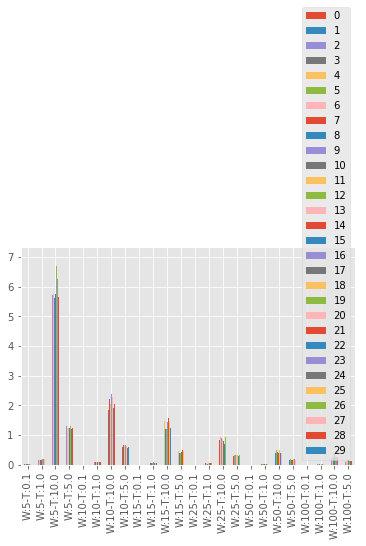

In [30]:
lists = sorted(summaries_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

# plt.plot(x, y)
# plt.show()
pd.DataFrame(summaries_dict).plot.bar()
plt.legend=None

In [ ]:
summary_df
summary_df['ratio']=summary_df[0]/summary_df[1]
summary_df.index
labels_names =summary_df.T.columns.values
new_labels_list =[new_label(labels_names[idx]) for idx, _ in enumerate(labels_names)]
test_df = summary_df.set_index([new_labels_list])

In [ ]:
ratios_dict.keys()

In [ ]:
def new_label(label):
    new_label=''.join(('W:',label.split('_')[4],'-T:',label.split('_')[9]))
    return new_label

In [ ]:
new_labels_list =[new_label(labels_names[idx]) for idx, _ in enumerate(labels_names)]

In [ ]:
summary_df.T.columns.values